In [7]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
import requests
from bs4 import BeautifulSoup
import bs4
from fastnumbers import isfloat 
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 

In [9]:
def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==np.float64:
        return string
    if type(string)==int or type(string)==np.int64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),
                      default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string

def get_children(html_content):
    return [item for item in html_content.children if 
            type(item)==bs4.element.Tag or 
            len(str(item).replace("\n","").strip())>0]

In [10]:
response = requests.get("https://finance.yahoo.com/gainers", timeout=240)
response.status_code

200

In [11]:
html = BeautifulSoup(response.content, "html.parser")

In [12]:
init_list = get_table_simple(html)
top5list = []
for x in range(6):
    top5list.append(init_list[x])
dftop5gainers = pd.DataFrame.from_records(top5list)
dftop5gainers

,0,1,2,3,4,5,6,7,8,9
0,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
1,ZS,"Zscaler, Inc.",98.09,+22.29,+29.41%,22.809M,3.037M,12.688B,N/A,None
2,PTKFF,PT Kalbe Farma Tbk.,0.1020,+0.0220,+27.50%,5.158M,"304,519",5.58B,N/A,None
3,TBVPF,Thai Beverage Public Company Limited,0.5500,+0.1150,+26.44%,"25,909","102,600",14.231B,25.00,None
4,PTXKY,PT XL Axiata Tbk,3.8000,+0.7200,+23.38%,"47,587","7,756",2.266B,N/A,None
5,NWAU,"Consumer Automotive Finance, Inc.",0.0225,+0.0028,+14.21%,"549,897","523,927",39.381B,N/A,None


In [5]:
df5183 = web.DataReader('5183.KL', data_source='yahoo', start='2011-03-12',end='2020-03-12')

In [6]:
df5183['Difference'] = df5183['Open'] - df5183['Close']
df5183.head()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2011-03-14,6.82,6.47,6.52,6.75,17068200.0,5.005249,-0.23
2011-03-15,6.77,6.56,6.75,6.59,17123100.0,4.886606,0.16
2011-03-16,6.67,6.58,6.62,6.63,13315400.0,4.916266,-0.01
2011-03-17,6.65,6.58,6.63,6.63,7634200.0,4.916266,0.00
2011-03-18,6.71,6.62,6.66,6.70,13221200.0,4.968173,-0.04


In [7]:
df5183.tail()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2020-03-06,5.67,5.52,5.64,5.65,3884700.0,5.566207,-0.01
2020-03-09,5.35,4.40,5.35,4.40,25781200.0,4.334746,0.95
2020-03-10,4.63,4.24,4.30,4.35,15704300.0,4.285487,-0.05
2020-03-11,4.79,4.38,4.45,4.72,13616300.0,4.650000,-0.27
2020-03-12,4.70,4.45,4.54,4.65,10009100.0,4.650000,-0.11


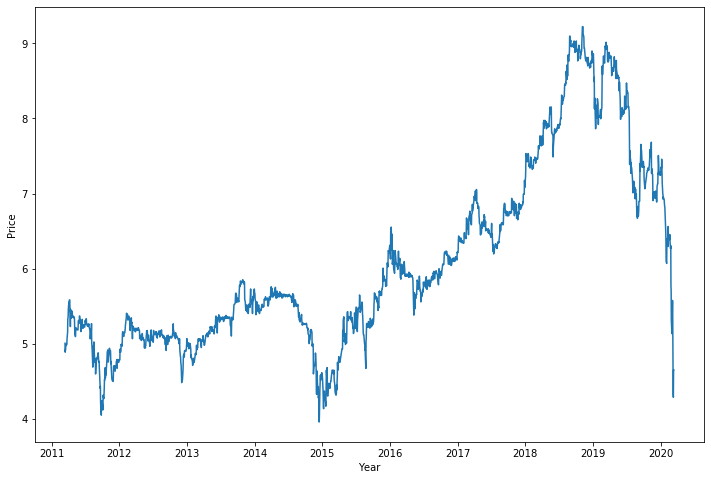

In [8]:
plt.figure(figsize = (12,8))
plt.plot(df5183['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [9]:
df5183.to_csv('pchem.csv')

In [10]:
dfPre = []
dfPre = df5183[['Adj Close']]

In [11]:
print(dfPre.head())

            Adj Close
Date                 
2011-03-14   5.005249
2011-03-15   4.886606
2011-03-16   4.916266
2011-03-17   4.916266
2011-03-18   4.968173


In [12]:
forecast_out = 30 #predict n days into the future, in this case, 30
dfPre['Prediction'] = dfPre[['Adj Close']].shift(-forecast_out)
print(dfPre.head())

            Adj Close  Prediction
Date                             
2011-03-14   5.005249    5.376008
2011-03-15   4.886606    5.361178
2011-03-16   4.916266    5.353763
2011-03-17   4.916266    5.346348
2011-03-18   4.968173    5.361178


C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
X = np.array(dfPre.drop(['Prediction'], 1))
len(X)

2225

In [14]:
#reserving 60 data for testing
X_new = X[0:2165]
len(X_new) + 60

2225

In [15]:
X_new[0:10]

array([[5.00524902],
       [4.88660622],
       [4.91626644],
       [4.91626644],
       [4.96817255],
       [4.97558975],
       [4.99783373],
       [4.99041843],
       [5.01266384],
       [5.06456995]])

In [16]:
y = np.array(dfPre['Prediction'])
y_new = y[:-60]
len(y_new)

2165

In [17]:
y_new[0:10]

array([5.37600803, 5.36117792, 5.35376263, 5.34634781, 5.36117792,
       5.35376263, 5.32410097, 5.24994993, 5.13130713, 5.09423065])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2)

In [19]:
y = np.array(dfPre['Prediction'])
y = y[:-forecast_out]
print(y)
len(y)

[5.37600803 5.36117792 5.35376263 ... 4.28548717 4.64999962 4.6500001 ]


2195

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
y_pre = lr.predict(X[2195:2225])
print("Predicted last 30 days")
print(y_pre)

Predicted last 30 days
[6.12006924 6.09174246 6.35612402 6.34668161 6.41277711 6.36556597
 6.30891288 6.56385203 6.43166148 6.41277711 6.41277711 6.45998825
 6.39389275 6.45054584 6.45998825 6.36556597 6.28058656 6.31835529
 5.79903504 5.75182436 5.37413707 5.19473538 5.27971525 5.46855889
 5.61963335 5.6101914  4.42991885 4.38270771 4.73206823 4.73206868]


In [22]:
confidence = lr.score(X_test, y_test)
print("Confidence Score: ", confidence)

Confidence Score:  0.9275446135023543


In [23]:
x_forecast = np.array(dfPre.drop(['Prediction'], 1))[-forecast_out:]
print("Actual last 30 days: ")
print(x_forecast)

Actual last 30 days: 
[[6.09819889]
 [6.06864357]
 [6.34449148]
 [6.33463955]
 [6.40360165]
 [6.35434294]
 [6.29523277]
 [6.56122875]
 [6.42330503]
 [6.40360165]
 [6.40360165]
 [6.45286036]
 [6.38389826]
 [6.44300842]
 [6.45286036]
 [6.35434294]
 [6.26567793]
 [6.30508471]
 [5.76324129]
 [5.71398306]
 [5.31991529]
 [5.13273287]
 [5.22139835]
 [5.41843224]
 [5.57605886]
 [5.56620741]
 [4.33474588]
 [4.28548717]
 [4.64999962]
 [4.6500001 ]]


Text(0, 0.5, 'Price')

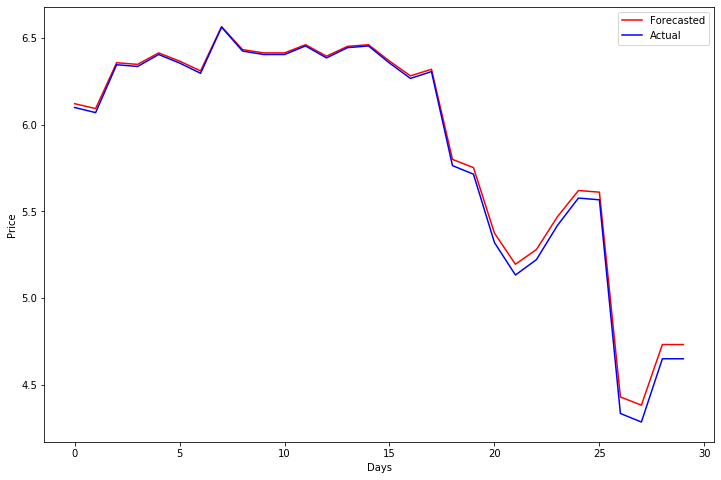

In [24]:
plt.figure(figsize = (12,8))
plt.plot(y_pre, color='r')
plt.plot(x_forecast, color='b')
plt.legend(['Forecasted', 'Actual'])
plt.xlabel("Days")
plt.ylabel("Price")

In [25]:
print("Mean Squared Error: ", metrics.mean_squared_error(y_pre, x_forecast))

Mean Squared Error:  0.001798060160948857


In [26]:
y_pre2 = [] 
y_pre2.append(np.array(y_pre))
for x in range(11):
    y_pre_alt = y_pre2[x]
    y_pre_in = lr.predict(y_pre_alt.reshape(-1, 1))
    y_pre2.append(np.array(y_pre_in))

In [27]:
forward = []
for x in y_pre2:
    for y in x:
        forward.append(y)

print(y_pre2)
print(forward)

[array([6.12006924, 6.09174246, 6.35612402, 6.34668161, 6.41277711,
       6.36556597, 6.30891288, 6.56385203, 6.43166148, 6.41277711,
       6.41277711, 6.45998825, 6.39389275, 6.45054584, 6.45998825,
       6.36556597, 6.28058656, 6.31835529, 5.79903504, 5.75182436,
       5.37413707, 5.19473538, 5.27971525, 5.46855889, 5.61963335,
       5.6101914 , 4.42991885, 4.38270771, 4.73206823, 4.73206868]), array([6.14103049, 6.11388119, 6.36727302, 6.35822311, 6.42157118,
       6.3763225 , 6.32202434, 6.56636626, 6.43967056, 6.42157118,
       6.42157118, 6.46681986, 6.40347179, 6.45776995, 6.46681986,
       6.3763225 , 6.29487548, 6.33107425, 5.83334093, 5.78809269,
       5.42610498, 5.2541606 , 5.33560805, 5.51660191, 5.66139655,
       5.65234708, 4.52113571, 4.47588702, 4.81072543, 4.81072587]), array([6.16112042, 6.13509966, 6.37795859, 6.36928486, 6.42999969,
       6.38663189, 6.33459079, 6.56877599, 6.44734673, 6.42999969,
       6.42999969, 6.4733675 , 6.41265266, 6.46469377, 6.

Text(0, 0.5, 'Price')

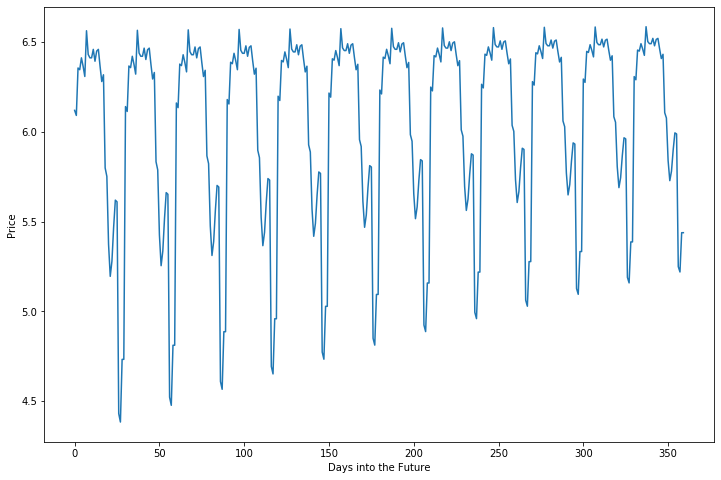

In [28]:
#The stock prices predicted from 1 day into the future, to a year into the future
plt.figure(figsize = (12,8))
plt.plot(forward)
plt.xlabel("Days into the Future")
plt.ylabel("Price")